# Analysis of droplets

This is a cleaned up version of the analysis made by Olof Jönsson 2018-2021 at KTH, together with Niloofar Esmaeildoost and Jonas Sellberg. 

No parts of this code can be used without proper citation to the upcoming article with main author Niloofar Esmaeildoost. Please contact Olof at olof.jnsson@gmail.com for other uses.



In [1]:
import os

import numpy as np
import cv2
import re  # for string splitting
import h5py

from scipy import signal
from series import Series


import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy.random as np_random
import random
import scipy.stats as stats
import matplotlib.cm as cm
import matplotlib.patches as patches

from scipy.interpolate import griddata
from scipy.interpolate import interp2d
from scipy.interpolate import RegularGridInterpolator


import gc
# %matplotlib

### Import of hdf5-data

In [2]:
def read_hdf5(path, filename):
    f = h5py.File('{0}/{1}'.format(path, filename), 'r')
    return f['data']['time'], f['data']['Tave']


# These are the sizes that are in the folder of hdf5 files. Must have the same timesteps
sizes = [3, 5, 10, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]

# sizes is the x
x = sizes

# y is the timesteps, and this is taken from the file t_calib_22.h5
time, _ = read_hdf5(
    '../Temperature_sims_and_interpolation/From_Niloo/Temp_sim_Jan2010/', 't_calib_22.h5')
y = list(time[:])

# Create an empy matrix with the size of the sizes and times
temperatures = np.zeros([len(x), len(y)])

# Filling the matrix with actual values measured.
for size_index, size_value in enumerate(sizes):
    _, temperatures[size_index] = read_hdf5(
        '../Temperature_sims_and_interpolation/From_Niloo/Temp_sim_Jan2010/', 't_calib_{0}.h5'.format(size_value))

# This is a function returned by the RegularGridInterpolator
#interpolate_T = interp2d(xx, yy, temperatures, kind='linear',bounds_error=True)
interpolate_T = RegularGridInterpolator((x, y), temperatures)

## Estimating count errors
Note that this method is NOT used in the MC! this is an independent method for finding the 95% confidence of a count. Here is a good explanation that also shows where the 1.96 vlue in Wilson comes from: https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval

In [3]:
def binomial_interval(n, p, method='Wald'):
    z = 1.96 #this is for 95% confidence. 
    if method == 'Wald':
        error = z*np.sqrt((1.0-p)*p/n)
    elif method == 'Agresti–Coull':
        error = z*np.sqrt((1.0-p)*p/(n+z*z))
    elif method == 'Wilson_upper':
        z = 1.96
        num = p+z*z/(2*n)+z*np.sqrt(p*(1-p)/n+z*z/(4*n*n))
        den = 1+(z*z)/n
        error = np.divide(num, den)
    elif method == 'Wilson_lower':
        z = -1.96
        num = p+z*z/(2*n)+z*np.sqrt(p*(1-p)/n+z*z/(4*n*n))
        den = 1+(z*z)/n
        error = np.divide(num, den)
    else:
        print('Not an implemented method specified')
    return error

count=149
fraction=0.12

print('For a count of ' + str(count))
print('And a fraction that is ' + str(fraction))
print('The count error limits will then be:')
print('Wilson method lower limit ' + str(binomial_interval(count, fraction, method='Wilson_lower')))
print('Wilson method higher limit ' + str(binomial_interval(count, fraction, method='Wilson_upper')))

For a count of 149
And a fraction that is 0.12
The count error limits will then be:
Wilson method lower limit 0.07715427572024146
Wilson method higher limit 0.18194795822653745


## Calculating nucleation rate

With Monte Carlo error analysis

### Entering measured data

In [4]:
# First make an object with a name, and a given interpolation function for T
dec7_with_types = Series('Dec 7 with types', interpolate_T)


#Define all the various measured datapoints

counts = np.multiply([633, 566, 298, 325], 1) #Counts of droplets in focus
fractions = [0.0458, 0.362, 0.9865, 1]  # ice fraction for focused
distances = np.multiply([40, 45, 47.5, 50], 0.001)  # in m


#Define all droplet types. 
sideblob_counts = [15, 50, 192, 176]
marbles_counts = [12, 149, 74, 15]
fractured_counts = [2, 6, 28, 134]
water_counts = [604, 361, 4, 0]
water_counts = [604, 361, 4, 2]

type_counts = np.array([sideblob_counts, marbles_counts,
                       fractured_counts, water_counts]).T

#Feed this to the set_observables method. 
# d is droplet diameter in m
# s is droplet spacing in m 
# q is flow rate in microliters/min

dec7_with_types.set_observables(frequency=398,
                                d_value=18.145e-6,
                                d_sigma=0.409e-6,
                                s_value=38.676e-6,
                                s_sigma=4.063e-6,
                                q_value=57.5,
                                distances=distances,
                                counts=counts,
                                fractions=fractions,
                                type_counts=type_counts)

# This is with the last half cutout, when the pressure dropped.
nov3_with_types = Series('Nov 3 with types', interpolate_T)

counts = np.multiply([48, 27, 34, 210, 715, 881, 797, 84], 1)
fractions = [0, 0.03, 0.00, 0.06, 0.04, 0.04,
             0.13, 0.35]  # ice fraction for focused
distances = np.multiply([15, 20, 25, 30, 35, 40, 45, 50], 0.001)  # in m

sideblob_counts = [0, 0, 0, 6, 12, 14, 62, 22]
marbles_counts = [0, 1, 0, 5, 12, 13, 31, 21]
fractured_counts = [0, 0, 0, 0, 0, 2, 0, 0]
distorted = [0, 0, 0, 2, 3, 6, 13, 6]
fractured_counts = np.add(fractured_counts, distorted)

# fractured vs distorted
water_counts = [48, 38, 34, 197, 688, 846, 691, 243]

type_counts = np.array([sideblob_counts, marbles_counts,
                       fractured_counts, water_counts]).T

nov3_with_types.set_observables(d_value=20.2e-6,
                                d_sigma=0.496e-6,
                                s_value=58.3e-6,
                                s_sigma=3.67e-6,
                                q_value=56.5,
                                distances=distances,
                                counts=counts,
                                fractions=fractions,
                                type_counts=type_counts)


'''
Data from https://docs.google.com/spreadsheets/d/11-GYikog0r1H5IH8vmNHlBlmi4fgEX_WUqMD0C2dIpY/edit#gid=0
and from https://docs.google.com/spreadsheets/d/1VOADjIf649fGTbqI5R4Td48dqzSHE5dx0zcEj2TWAcc/edit#gid=2063575402
'''
mar12_with_types = Series('Mar 12 with types', interpolate_T)
counts = np.multiply([357,
                      183,
                      105,
                      158,
                      113,
                      471,
                      319,
                      406,
                      327,
                      454,
                      206,
                      220], 1)
fractions = [0, 0, 0, 0, 0.01769911504, 0.05732484076, 0.09404388715, 0.06896551724,
             0.07339449541, 0.1696035242, 0.6213592233, 0.9181818182]  # ice fraction for focused

sideblob_counts = [0,
                   0,
                   0,
                   0,
                   1,
                   16,
                   23,
                   19,
                   17,
                   34,
                   50,
                   140]
marbles_counts = [0,
                  0,
                  0,
                  0,
                  1,
                  9,
                  4,
                  4,
                  3,
                  36,
                  70,
                  39]
distorted = [0, 0, 0, 0, 0, 2, 3, 2, 3, 2, 2, 7]
fractured_counts = [0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    3,
                    1,
                    5,
                    6,
                    16]
fractured_sum_counts = np.add(fractured_counts, distorted)
water_counts = [357, 183, 105, 158, 111, 444, 289, 378, 303, 377, 78, 18]


type_counts = np.array([sideblob_counts, marbles_counts,
                       fractured_sum_counts, water_counts]).T

distances = np.multiply(
    [11, 16, 20, 25, 30, 35, 37.5, 40, 42.5, 45, 47.5, 50], 0.001)  # in m
mar12_with_types.set_observables(d_value=21.44656962e-6,
                                 d_sigma=1.400e-6,
                                 s_value=58.3e-6,
                                 s_sigma=3.67e-6,
                                 q_value=55.1,
                                 distances=distances,
                                 counts=counts,
                                 fractions=fractions,
                                 type_counts=type_counts)


'''
Data from https://docs.google.com/spreadsheets/d/11-GYikog0r1H5IH8vmNHlBlmi4fgEX_WUqMD0C2dIpY/edit#gid=0
and from https://docs.google.com/spreadsheets/d/1VOADjIf649fGTbqI5R4Td48dqzSHE5dx0zcEj2TWAcc/edit#gid=2063575402
'''
mar12_with_types = Series('Mar 12 with types', interpolate_T)
counts = np.multiply([357,
                      183,
                      105,
                      158,
                      113,
                      471,
                      319,
                      406,
                      327,
                      454,
                      206,
                      220], 1)
fractions = [0, 0, 0, 0, 0.01769911504, 0.05732484076, 0.09404388715, 0.06896551724,
             0.07339449541, 0.1696035242, 0.6213592233, 0.9181818182]  # ice fraction for focused

sideblob_counts = [0,
                   0,
                   0,
                   0,
                   1,
                   16,
                   23,
                   19,
                   17,
                   34,
                   50,
                   140]
marbles_counts = [0,
                  0,
                  0,
                  0,
                  1,
                  9,
                  4,
                  4,
                  3,
                  36,
                  70,
                  39]
distorted = [0, 0, 0, 0, 0, 2, 3, 2, 3, 2, 2, 7]
fractured_counts = [0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    3,
                    1,
                    5,
                    6,
                    16]
fractured_sum_counts = np.add(fractured_counts, distorted)
water_counts = [357, 183, 105, 158, 111, 444, 289, 378, 303, 377, 78, 18]


type_counts = np.array([sideblob_counts, marbles_counts,
                       fractured_sum_counts, water_counts]).T

distances = np.multiply(
    [11, 16, 20, 25, 30, 35, 37.5, 40, 42.5, 45, 47.5, 50], 0.001)  # in m
mar12_with_types.set_observables(d_value=21.44656962e-6,
                                 d_sigma=1.400e-6,
                                 s_value=58.3e-6,
                                 s_sigma=3.67e-6,
                                 q_value=55.1,
                                 distances=distances,
                                 counts=counts,
                                 fractions=fractions,
                                 type_counts=type_counts)

'''
Data from https://docs.google.com/spreadsheets/d/1vLBLDDu8vQx1R1nRL9ML0Zp7wrktrKi3laL0rhxsNr8/edit#gid=81409557
'''
may11_with_types = Series('May 11 2021', interpolate_T)
counts = np.multiply([342,304,450,599], 1)
fractions = [0.005847953216,0.01644736842,0.08666666667,0.3372287145]  # ice fraction for focused

sideblob_counts = [0,2,10,35]
marbles_counts = [2,3,29,166]
distorted = [0,0,0,0]
fractured_counts = [0,0,0,1]
fractured_sum_counts = np.add(fractured_counts, distorted)
water_counts = [340,299,411,397]


type_counts = np.array([sideblob_counts, marbles_counts,
                       fractured_sum_counts, water_counts]).T

distances = np.multiply(
    [37,42,45,47.77], 0.001)  # in m
may11_with_types.set_observables(s_value=80.4771e-6,
                                 s_sigma=1.2677e-6,
                                 d_value=24.9751e-6,
                                 d_sigma=0.3930e-6,
                                 q_value=58.07142857,
                                 distances=distances,
                                 counts=counts,
                                 fractions=fractions,
                                 type_counts=type_counts)

korv
korv
korv
korv
korv


/Users/olofjonsson/Projects/Ice/Droplet_codes/Examples/series.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if type_counts[0] != 'korv':
/Users/olofjonsson/Projects/Ice/Droplet_codes/Examples/series.py:334: RuntimeWarning: divide by zero encountered in true_divide
  the_log = np.log(np.divide(np.subtract(1, f_2), np.subtract(1, f_1)))
/Users/olofjonsson/Projects/Ice/Droplet_codes/Examples/series.py:365: RuntimeWarning: divide by zero encountered in log
  fractions_log=np.log(np.subtract(1,fractions)) #It's the water fractions we use


### Running the error simulation and saving the results

Use as many trials as needed, until the values converge

In [5]:
experiments = [dec7_with_types, nov3_with_types, mar12_with_types,may11_with_types]
#experiments=[may11_with_types]



trials = 10000 #This is the number of trials
results_path='Results_MC'


for series in experiments:
    print(series.descriptor)
    series.calculate_errors(percentile=15.865, do_J=True, trials=trials)
    series.generate_plotting_label()
    series.save_column_file(results_path)
    series.save_hdf5_file(results_path)



Dec 7 with types


/Users/olofjonsson/.virtualenvs/opython/lib/python3.8/site-packages/numpy/lib/function_base.py:1080: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/Users/olofjonsson/.virtualenvs/opython/lib/python3.8/site-packages/numpy/lib/function_base.py:1096: RuntimeWarning: invalid value encountered in double_scalars
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n
/Users/olofjonsson/Projects/Ice/Droplet_codes/Examples/series.py:334: RuntimeWarning: invalid value encountered in true_divide
  the_log = np.log(np.divide(np.subtract(1, f_2), np.subtract(1, f_1)))


Results_MC/Dec_7_with_types_all_data.h5
Nov 3 with types
Results_MC/Nov_3_with_types_all_data.h5
Mar 12 with types
Results_MC/Mar_12_with_types_all_data.h5
May 11 2021
Results_MC/May_11_2021_all_data.h5


### Example of how to extract data

This is to extract data straight out from the objects, in this case to make a plot

/Users/olofjonsson/.virtualenvs/opython/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


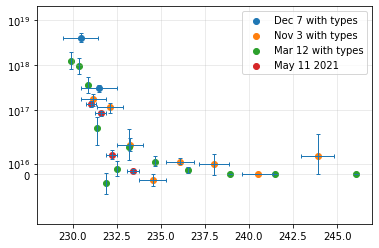

In [6]:
plt.figure()
ax2=plt.gca()
for series in experiments:
    
    xerr = np.array([series.low_T_err_at_measured, series.high_T_err_at_measured])
    yerr = np.array([series.low_J_err, series.high_J_err])

    ax2.scatter(series.ideal_T_at_measured,
               series.ideal_J,label=series.descriptor)
    ax2.errorbar(series.ideal_T_at_measured,
                series.ideal_J,
                xerr=xerr,
                yerr=yerr,
                fmt='none',
                capsize=2, lw=1)
ax2.legend()

ax2.set_yscale('symlog', linthresh=5e16)
ax2.set_ylim(bottom=-0.5e17,top=2e19)
ax2.set_xlim(left=228,right=247)
ax2.grid(alpha=0.3)

### Example of how to extract data from all trials

Text(0, 0.5, 'temperatures')

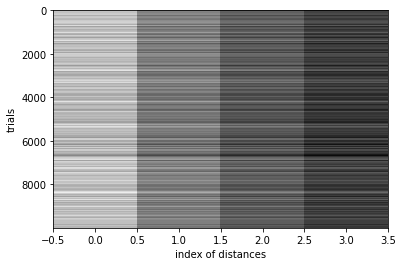

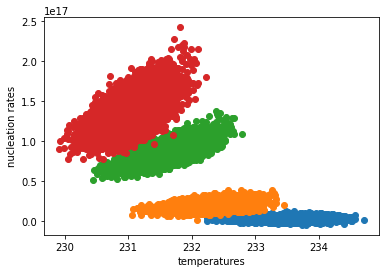

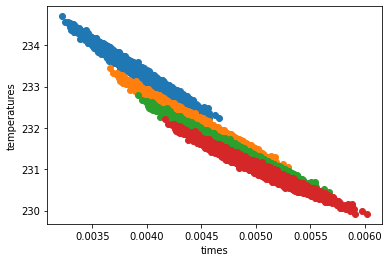

In [7]:
#generate a colormap showing bad datapoints
cmap_with_bad = plt.get_cmap('gray').with_extremes(bad='r', under='g', over='b')

#extract the matrices of all trials
temperatures=may11_with_types.T_MC_matrix_at_measured 
times=may11_with_types.t_MC_matrix_at_measured 
velocities=may11_with_types.v_MC_matrix_at_measured 
nucleation_rates=may11_with_types.J_MC_matrix_at_measured

#extract the distances
distances=may11_with_types.measured_distances

#these matrices have dimension number of trials*number of distances
plt.figure()
plt.imshow(temperatures,interpolation='none',aspect='auto',cmap=cmap_with_bad)
plt.xlabel('index of distances')
plt.ylabel('trials')


#nucleation rates, all points
plt.figure()
for distance_index,distance in enumerate(distances):
    plt.scatter(temperatures[:,distance_index],nucleation_rates[:,distance_index])
plt.xlabel('temperatures')
plt.ylabel('nucleation rates')
    
#temperature vs time, all points
plt.figure()
for distance_index,distance in enumerate(distances):
    plt.scatter(times[:,distance_index],temperatures[:,distance_index])
plt.xlabel('times')
plt.ylabel('temperatures')

### Dealing with fraction matrices

Each point is a simulated fraction.

Each row will sum to 1, and represents the types in the same order as inputed, here is is sideblobs, marbles, fractured, water.

each column is one distance.

[[0.         0.00292398 0.         0.99707602]
 [0.00328947 0.01644737 0.         0.98026316]
 [0.02222222 0.07111111 0.         0.90666667]
 [0.06510851 0.24874791 0.         0.68614357]]


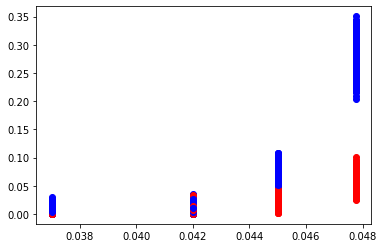

In [8]:
fractions=may11_with_types.type_fraction_MC_matrix_at_measured
#This is a matrix for the first trial
print(fractions[0])


#plotting sideblobs for each distance
sideblobs=[]
marbles=[]
distances=may11_with_types.measured_distances
for fraction_block in fractions:
    
    sideblob_evolution_in_this_trial=fraction_block[:,0]
    sideblobs.append(sideblob_evolution_in_this_trial) #sideblobs have index 0, see above
    
    marbles_evolution_in_this_trial=fraction_block[:,1]
    marbles.append(marbles_evolution_in_this_trial) #marbles have index 0, see above
    
    plt.scatter(distances,sideblob_evolution_in_this_trial,alpha=1,color='red')
    plt.scatter(distances,marbles_evolution_in_this_trial,alpha=1,color='blue')